In [14]:
import cdh23.loadData
import cdh23.analyzeData
from pathlib import Path
import sys 
import os
import numpy as np
import importlib

sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")),"Code","Travis"))
print(sys.path)
import responses_analysis
import utils 
import config

data_path = config.data_path
save_path = config.save_path

if not save_path.exists():
        save_path.mkdir()
colors_ito = {'black':[0,0,0], 'orange':[230,159,0], 'skyblue':[86,180,233], 'green':[0,158,115],
        'yellow':[240,228,66], 'blue':[0,114,178], 'darkorange':[213,94,0], 'purple': [204,121,167]}
colors_ito = {key: (np.array(colors_ito[key])/255).tolist() for key in colors_ito.keys()}
colors = [colors_ito['blue'],colors_ito['skyblue'],colors_ito['green'],colors_ito['yellow'],colors_ito["darkorange"]]
colors

['c:\\Users\\travisb\\Dropbox (Personal)\\Cdh23\\Code\\Travis', 'c:\\Users\\travisb\\Dropbox (Personal)\\Cdh23\\Code\\Travis', 'c:\\Users\\travisb\\Dropbox (Personal)\\Cdh23\\Code\\Travis', 'c:\\Users\\travisb\\Dropbox (Personal)\\Travis', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\python39.zip', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\DLLs', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p', '', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages', 'c:\\users\\travisb\\documents\\repos\\suite2p', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\win32', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\win32\\lib', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\Pythonwin', 'c:\\Users\\travisb\\miniconda3\\envs\\suite2p\\lib\\site-packages\\setuptools\\_vendor']


[[0.0, 0.4470588235294118, 0.6980392156862745],
 [0.33725490196078434, 0.7058823529411765, 0.9137254901960784],
 [0.0, 0.6196078431372549, 0.45098039215686275],
 [0.9411764705882353, 0.8941176470588236, 0.25882352941176473],
 [0.8352941176470589, 0.3686274509803922, 0.0]]

In [15]:
###subroutine to reanalyze all mice to get confusion matrices out of the analysis
import cdh23.analyzeData_minimal
import pandas as pd

test = utils.findUnanalyzedStacks(data_path, pattern="**/2P/L23/[0-9]*", foldername="all")
twop_mice = responses_analysis.get2Pmice(data_path, test)

accuracies, accuracies_chance, cws_accuracies, cws_chance, confusion_matrices, mice = ([] for i in range(6))

for i, row in twop_mice.iterrows():
    mouse = row['Mouse']
    folds = 10
    data = cdh23.loadData.loadTheData([mouse], data_path)
    ordered = data.processAndSort(mouse)
    analyzer = cdh23.analyzeData_minimal.analyzeTheData(ordered[0][0], ordered[1][0], mouse, "F1_Ahl")
    Xr_sc = analyzer.getZScoredConcat()
    mean_accuracy, mean_accuracy_chance, cw_accuracies, cw_chance, cms = analyzer.kFolds_classify(Xr_sc, folds)

    accuracies.append(mean_accuracy)
    accuracies_chance.append(mean_accuracy_chance)
    cws_accuracies.append(cw_accuracies)
    cws_chance.append(cw_chance)
    confusion_matrices.append(np.stack(cms,axis=-1).sum(axis=-1))
    mice.append(mouse)

df = pd.DataFrame({'Mouse':mice, "mean_accuracy": accuracies, "mean_accuracy_chance":accuracies_chance,
                    'cw_accuracies':cws_accuracies, 'cw_chance':cws_chance, 'confusion_matrix':confusion_matrices})

**/2P/L23/[0-9]* all
------------------
Mouse: m602
------------------
Loading data...
Date: 220317
Calculating dF...
Neurons x Time: (663, 14000)
Loading stim history...
Accuracy- LDA fit on PCA: 0.63
Chance Accuracy- LDA fit on PCA with shuffled labels: 0.07
Classwise accuracy
------------------
Mouse: m603
------------------
Loading data...
Date: 220422
Calculating dF...
Neurons x Time: (704, 14000)
Loading stim history...
Accuracy- LDA fit on PCA: 0.54
Chance Accuracy- LDA fit on PCA with shuffled labels: 0.06
Classwise accuracy
------------------
Mouse: m609
------------------
Loading data...
Date: 220317
Calculating dF...
Neurons x Time: (684, 14000)
Loading stim history...
Accuracy- LDA fit on PCA: 0.29
Chance Accuracy- LDA fit on PCA with shuffled labels: 0.04
Classwise accuracy
------------------
Mouse: m670
------------------
Loading data...
Date: 220422
Calculating dF...
Neurons x Time: (1529, 14000)
Loading stim history...
Accuracy- LDA fit on PCA: 0.82
Chance Accuracy- LDA

(0.0, 20.0)
(0.0, 20.0)
(0.0, 20.0)
(0.0, 20.0)
(0.0, 20.0)
(0.0, 20.0)


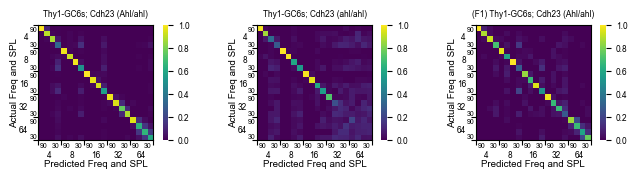

In [20]:
twop_df = twop_mice.merge(df, on="Mouse")
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

def transform_xticklabels(fig, ax, dx, dy):
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)

def transform_yticklabels(fig, ax, dx, dy):
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax.yaxis.get_majorticklabels():
            label.set_transform(label.get_transform() + offset)

fig, axs = plt.subplots(1,3, figsize=(8,1.5))
for i, geno in enumerate(twop_df['Genotype'].unique()):
    temp = twop_df[twop_df['Genotype']==geno]
    group_cm = np.stack(temp['confusion_matrix'], axis=-1)
    group_cm = group_cm.sum(axis=-1)
    group_cm = np.divide(group_cm,group_cm.sum(axis=0) )
    axs[i].set_title(geno, fontsize=6)
    
    sns.heatmap(data = group_cm, ax=axs[i], square='True', cmap='viridis')
    print(axs[i].get_xlim())
    axs[i].set_aspect('equal','box')
    axs[i].set_xticks(np.arange(0,21,4))
    axs[i].set_xticklabels(["4","8","16","32","64",""], rotation=0, fontsize=6)
    transform_xticklabels(fig, axs[i], dx=8/72, dy=0)
    
    axs[i].set_yticks(np.arange(0,21,4))
    axs[i].set_yticklabels(["4","8","16","32","64",""], rotation=0, fontsize=6)
    transform_yticklabels(fig, axs[i], dx=0, dy=-9/72)
    axs[i].axis('on')
    axs[i].spines[:].set_visible(True)
    axs[i].set_xlabel("Predicted Freq and SPL", fontsize=7, labelpad=0)
    axs[i].set_ylabel("Actual Freq and SPL", fontsize=7, labelpad=0)
    for j in range(5):
        axs[i].text(-1.5, 1.1+(4*j), "90", fontsize=5)
        axs[i].text(-1.5, 3.7+(4*j), "30", fontsize=5)
        axs[i].text(0.3+(4*j), 21.2, "90", fontsize=5)
        axs[i].text(2.4+(4*j), 21.2, "30", fontsize=5)
    #axs[i].get_legend().remove()
    print(axs[i].get_xlim())

plt.savefig(save_path / "Fig5_BC_SF2E_confusion_matrices.svg")

------------------
Mouse: m675
------------------
Loading data...
Date: 220422
Calculating dF...
Neurons x Time: (1984, 14000)
Loading stim history...
(1984, 200)


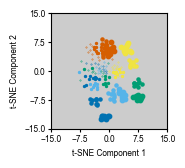

In [21]:
### example Ahl+ mouse tSNE plot

s = [10,5,2,.1]
mouse = 'm675'
data = cdh23.loadData.loadTheData([mouse], data_path)
ordered = data.processAndSort(mouse)

analyzer = cdh23.analyzeData.analyzeTheData(ordered[0][0], ordered[1][0], mouse, "F1_Ahl")
analyzer.pal = colors
fig, ax = analyzer.tsne2_figure(s=s,alphas=[1,1,1,1], figsize = [1.5,1.5])

import plotting
import matplotlib.pyplot as plt
plotting.figQuality(fig, ax)
ax.spines[['right', 'top']].set_visible(True)
#analyzer.add_orientation_legend(fig.get_axes()[0])
plt.savefig(save_path / "Fig5_C_Ahl+_example.svg")

------------------
Mouse: m2065
------------------
Loading data...
Date: 230605
Calculating dF...
Neurons x Time: (1739, 14000)
Loading stim history...
(1739, 200)


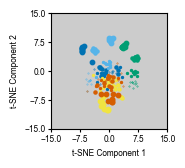

In [22]:
### example B6 mouse tSNE plot

mouse = 'm2065'
data = cdh23.loadData.loadTheData([mouse], data_path)
ordered = data.processAndSort(mouse)

analyzer = cdh23.analyzeData.analyzeTheData(ordered[0][0], ordered[1][0], mouse, "F1_Ahl")
analyzer.pal = colors
fig, ax = analyzer.tsne2_figure(s=s,alphas=[1,1,1,1], figsize=[1.5,1.5])

import plotting
import matplotlib.pyplot as plt
plotting.figQuality(fig, ax)
ax.spines[['right', 'top']].set_visible(True)
#analyzer.add_orientation_legend(fig.get_axes()[0])
plt.savefig(save_path / "Fig5_B_B6_example.svg")



------------------
Mouse: m722
------------------
Loading data...
Date: 220506
Calculating dF...
Neurons x Time: (1403, 14000)
Loading stim history...
(1403, 200)


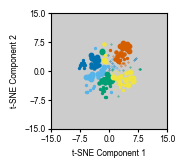

In [23]:
### example B6 mouse tSNE plot

mouse = 'm722'
data = cdh23.loadData.loadTheData([mouse], data_path)
ordered = data.processAndSort(mouse)

analyzer = cdh23.analyzeData.analyzeTheData(ordered[0][0], ordered[1][0], mouse, "F1_Ahl")
analyzer.pal = colors
fig, ax = analyzer.tsne2_figure(s=s,alphas=[1,1,1,1], figsize=[1.5,1.5])

import plotting
import matplotlib.pyplot as plt
plotting.figQuality(fig, ax)
ax.spines[['right', 'top']].set_visible(True)
#analyzer.add_orientation_legend(fig.get_axes()[0])
plt.savefig(save_path / "SF2_E_CBA_B6_example.svg")
